In [1]:
!pip install albumentations -U
!pip install opencv-python-headless==4.1.2.30

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset

from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
from math import log10
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Создание модели DnCNN

In [4]:
class DnCNN(nn.Module):
  def __init__(self, n_layers=18):
    super(DnCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False)
    self.relu1 = nn.ReLU(inplace=True)

    hidden_layers = []
    for _ in range(n_layers):
      hidden_layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
      hidden_layers.append(nn.BatchNorm2d(64))
      hidden_layers.append(nn.ReLU(inplace=True))
    self.hidden = nn.Sequential(*hidden_layers)
    self.out = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=False)

  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.hidden(out)
    out = self.out(out)
    return out

In [5]:
model = DnCNN(n_layers=17).to(device)
model.eval()
output = model(torch.ones(1, 3, 100, 100).to(device))

In [6]:
output.shape

torch.Size([1, 3, 100, 100])

## Создание датасета

In [7]:
class UniversalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, gaussian_noise_level=(0, 55),
                 transform=None):
      self.data = dataset
      self.transforms = transform
      self.gaussian_noise_level = gaussian_noise_level

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
      clean_image, label = self.data.__getitem__(idx)

      noisy_image = clean_image.copy()
      gaussian_noise = np.zeros((100, 100, 3), dtype=np.float32)

      sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
      gaussian_noise += np.random.normal(0.0, sigma, (100, 100, 3)).astype(np.float32)

      image = np.array(clean_image)
      image = cv2.resize(image, (100, 100))
      noisy_image = cv2.resize(np.array(noisy_image), (100, 100)).astype(np.float32)

      if self.transforms:
        img = self.transforms(image=image)['image']

      noisy_image += gaussian_noise
      # return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image)
      return img, torch.Tensor(image), torch.Tensor(gaussian_noise), torch.Tensor(noisy_image).permute(2,0,1)

In [8]:
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [9]:
train_transforms = A.Compose(
[
      A.OneOf([
               A.GaussNoise(var_limit=(10, 100), p=1),
               A.ISONoise(intensity=(0.3, 0.9), p=1),
               A.MultiplicativeNoise(p=1)
               ]),
      ToTensorV2()
])
dataset = UniversalDataset(torchvision.datasets.STL10('.../train', download=True),
                           transform=train_transforms)

Files already downloaded and verified


### Проверка датасета

In [10]:
img1, img2, img3, img4 = dataset.__getitem__(0)

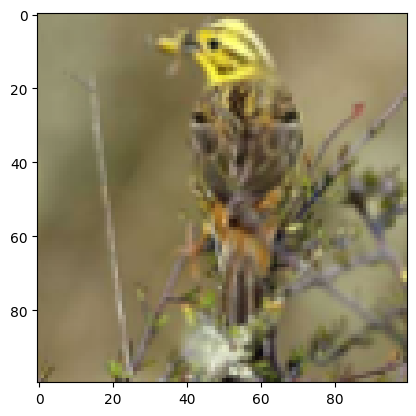

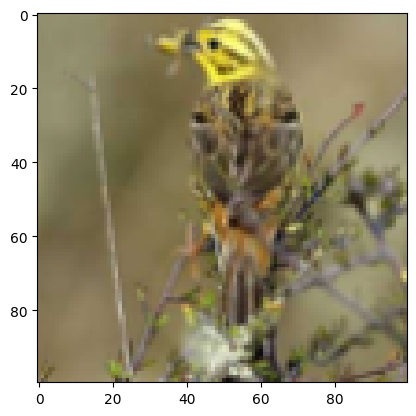

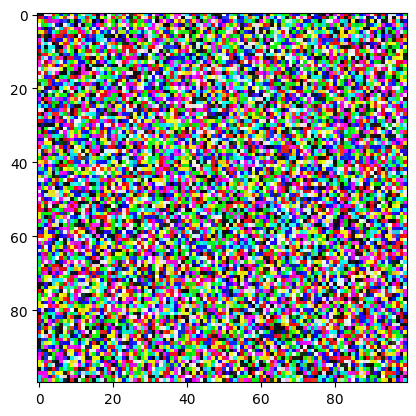

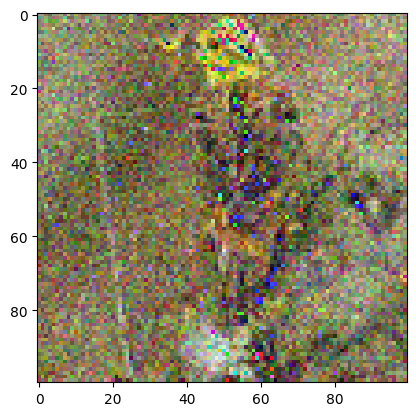

In [11]:
plt.imshow(img1.permute(1, 2, 0).numpy())
plt.show()

plt.imshow(img2.numpy().astype(np.uint8))
plt.show()

plt.imshow(img3.numpy().astype(np.uint8))
plt.show()

plt.imshow(img4.permute(1, 2, 0).numpy().astype(np.uint8))
plt.show()

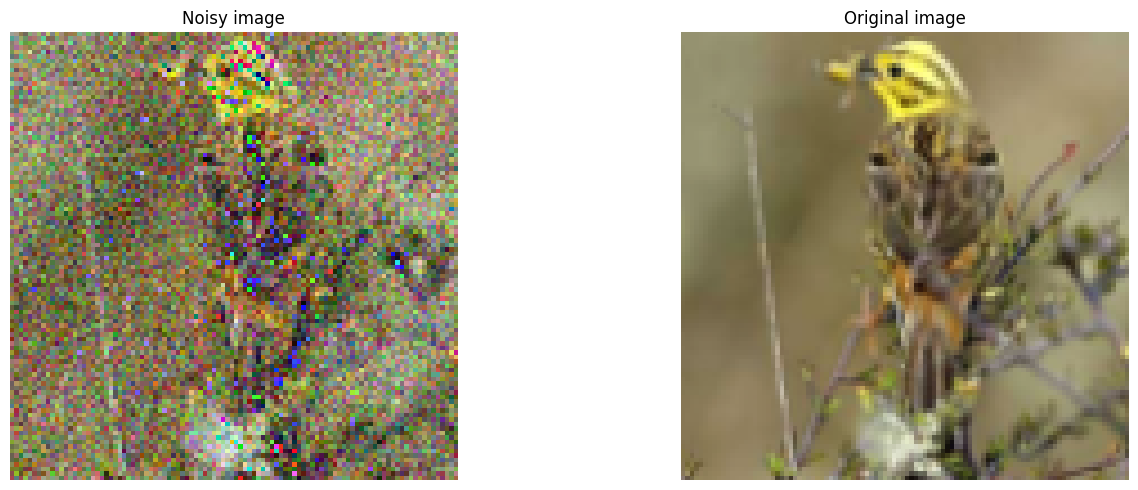

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(img4.permute(1, 2, 0).numpy().astype(np.uint8)), plt.axis('off'), plt.title('Noisy image', fontsize=12)
plt.subplot(122), plt.imshow(img1.permute(1, 2, 0).numpy()), plt.axis('off'), plt.title('Original image', fontsize=12)
plt.tight_layout()
plt.show()

## Обучение модели

In [13]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['val']

batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
model = model.to(device)

In [14]:
epochs = 25
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model.train()
  for iteration, data in enumerate(train_dataloader):

      # input, target, _, _ = data
      _, target, _, input = data
      input, target = input.to(device)/255, target.to(device)/255

      output = model(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      # print("===> Epoch[{}]({}/{}): "
      #       "Loss: {:.4f}".format(epoch, iteration,
      #                             len(train_dataloader),
      #                             loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    epoch_loss / len(train_dataloader)))


  avg_psnr = 0
  model.eval()
  with torch.no_grad():
      for data in train_dataloader:
        # input, target, _, _ = data
        _, target, _, input = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

===> Epoch 1 Complete: Avg. Loss: 0.1290
===> Avg. PSNR: 7.9765 dB
===> Epoch 2 Complete: Avg. Loss: 0.0186
===> Avg. PSNR: 13.9505 dB
===> Epoch 3 Complete: Avg. Loss: 0.0119
===> Avg. PSNR: 19.7617 dB
===> Epoch 4 Complete: Avg. Loss: 0.0093
===> Avg. PSNR: 20.1324 dB
===> Epoch 5 Complete: Avg. Loss: 0.0081
===> Avg. PSNR: 21.1661 dB
===> Epoch 6 Complete: Avg. Loss: 0.0074
===> Avg. PSNR: 20.9894 dB
===> Epoch 7 Complete: Avg. Loss: 0.0068
===> Avg. PSNR: 21.8801 dB
===> Epoch 8 Complete: Avg. Loss: 0.0064
===> Avg. PSNR: 21.6813 dB
===> Epoch 9 Complete: Avg. Loss: 0.0060
===> Avg. PSNR: 22.2861 dB
===> Epoch 10 Complete: Avg. Loss: 0.0057
===> Avg. PSNR: 22.0981 dB
===> Epoch 11 Complete: Avg. Loss: 0.0055
===> Avg. PSNR: 23.0208 dB
===> Epoch 12 Complete: Avg. Loss: 0.0052
===> Avg. PSNR: 23.1471 dB
===> Epoch 13 Complete: Avg. Loss: 0.0050
===> Avg. PSNR: 23.3830 dB
===> Epoch 14 Complete: Avg. Loss: 0.0049
===> Avg. PSNR: 23.1277 dB
===> Epoch 15 Complete: Avg. Loss: 0.0047
==

### Визуализация результатов

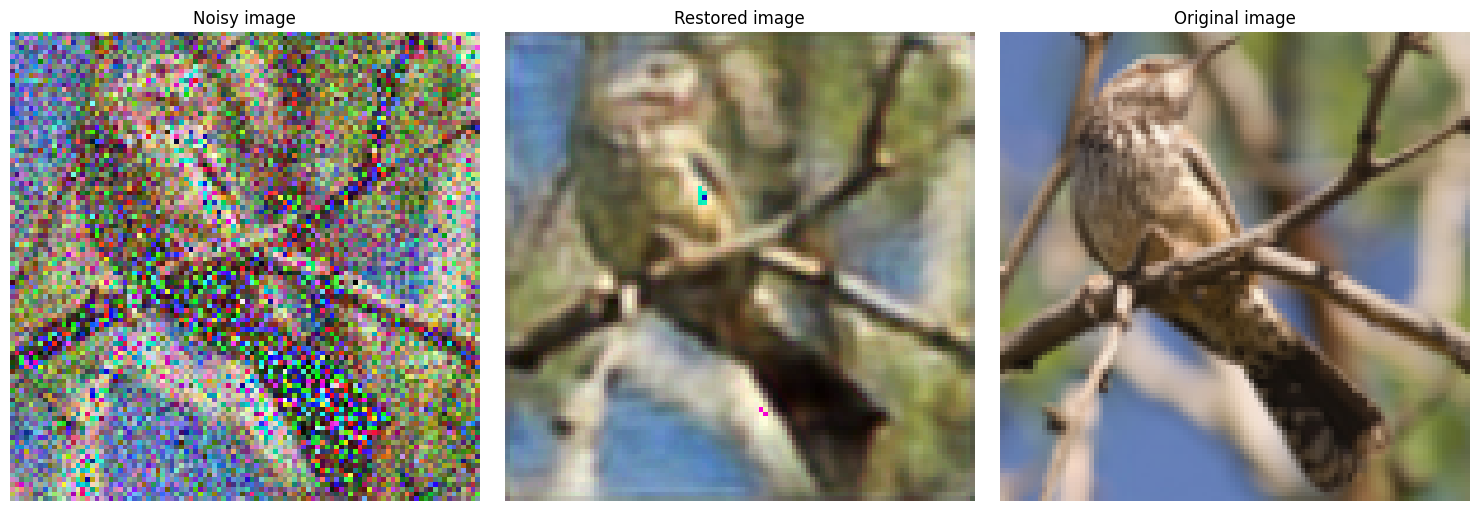

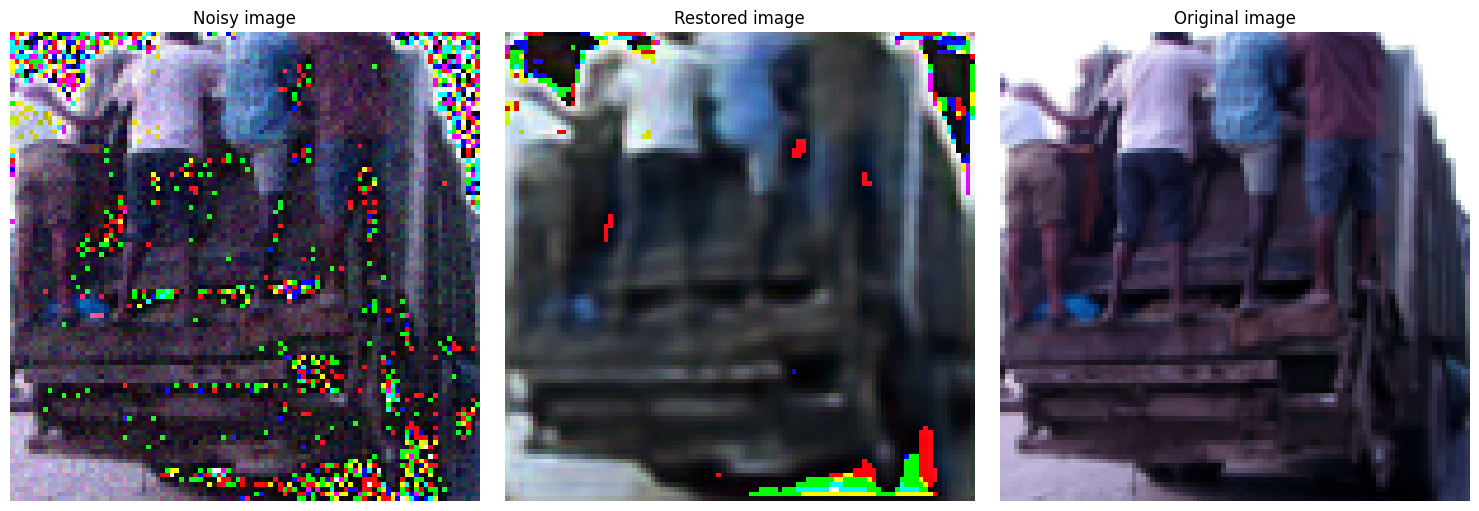

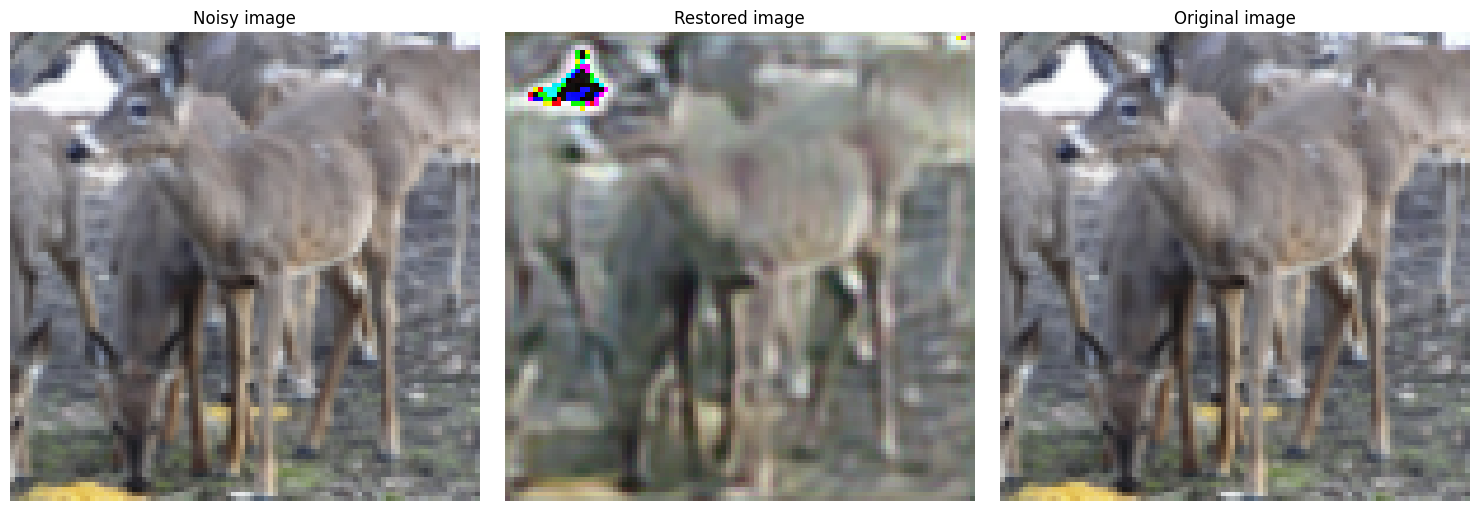

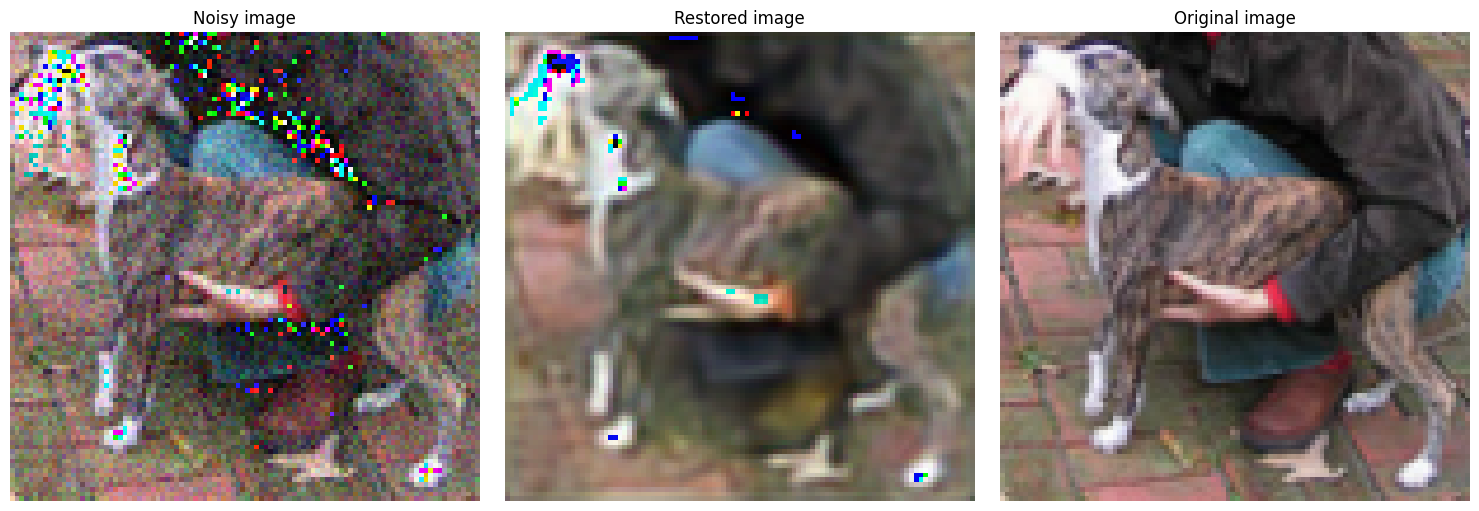

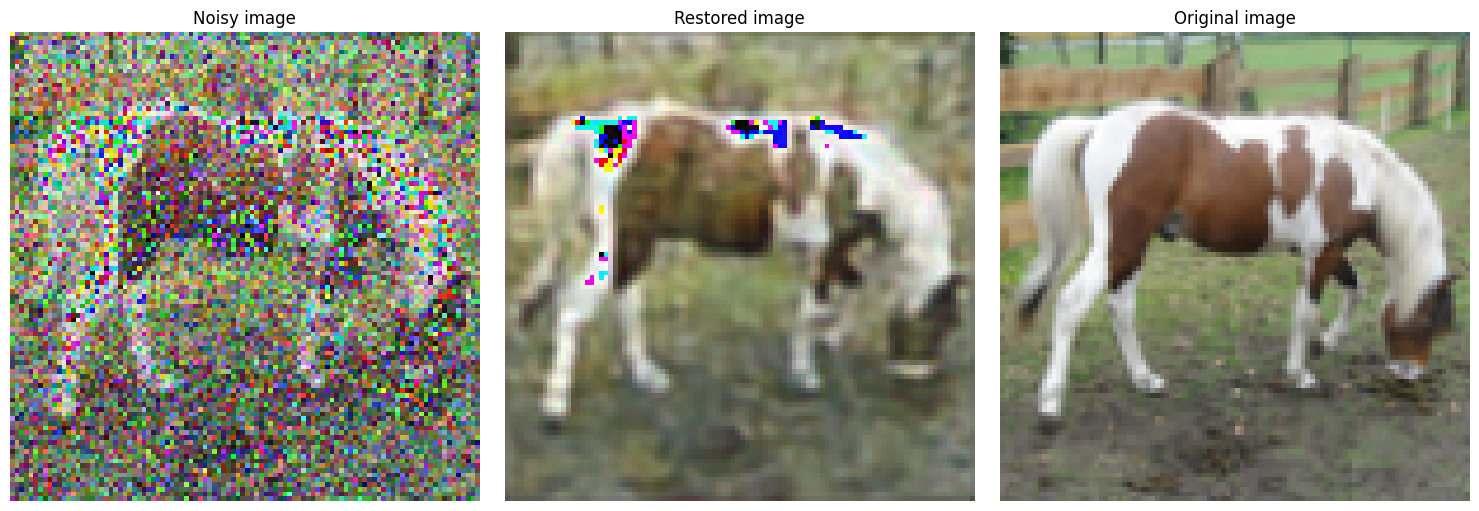

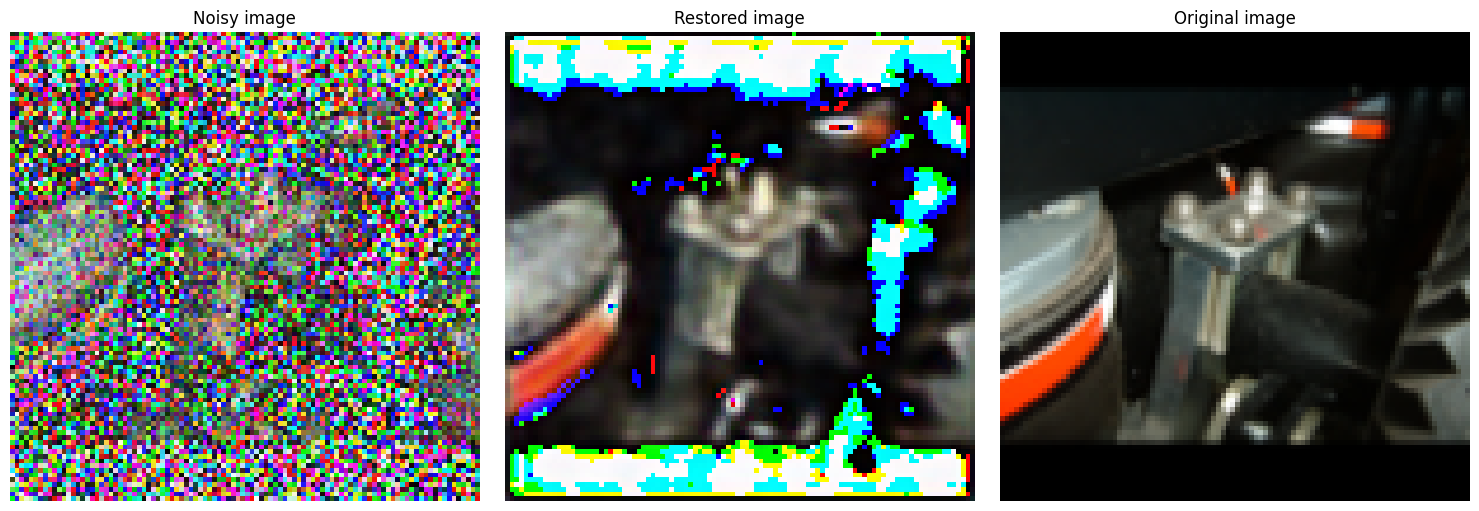

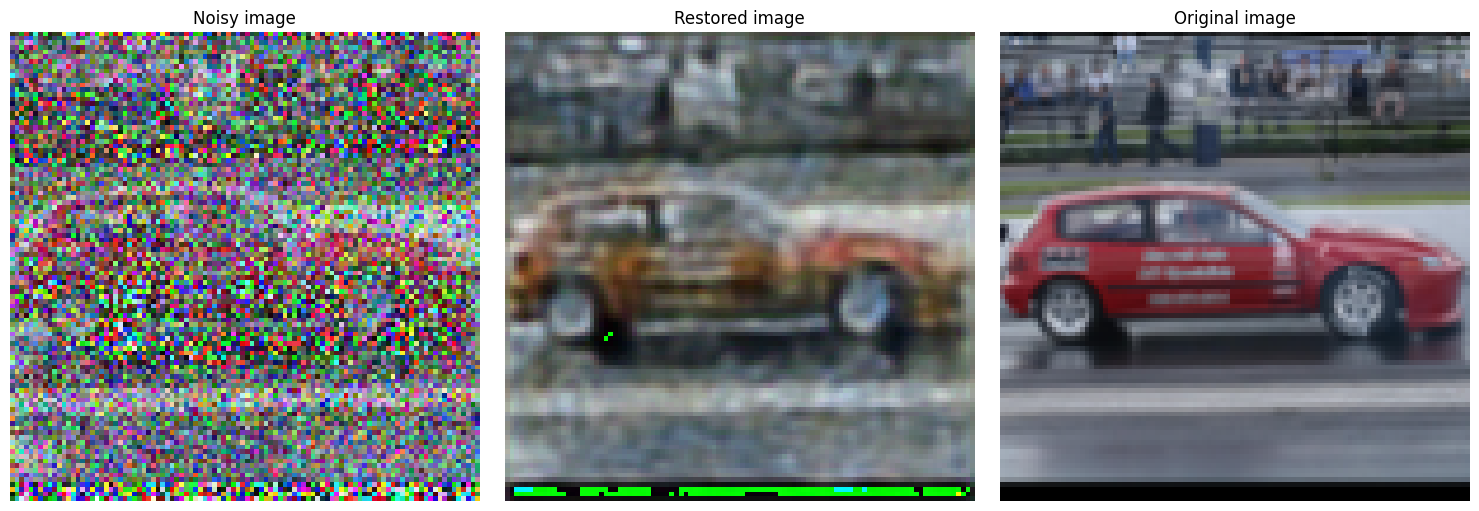

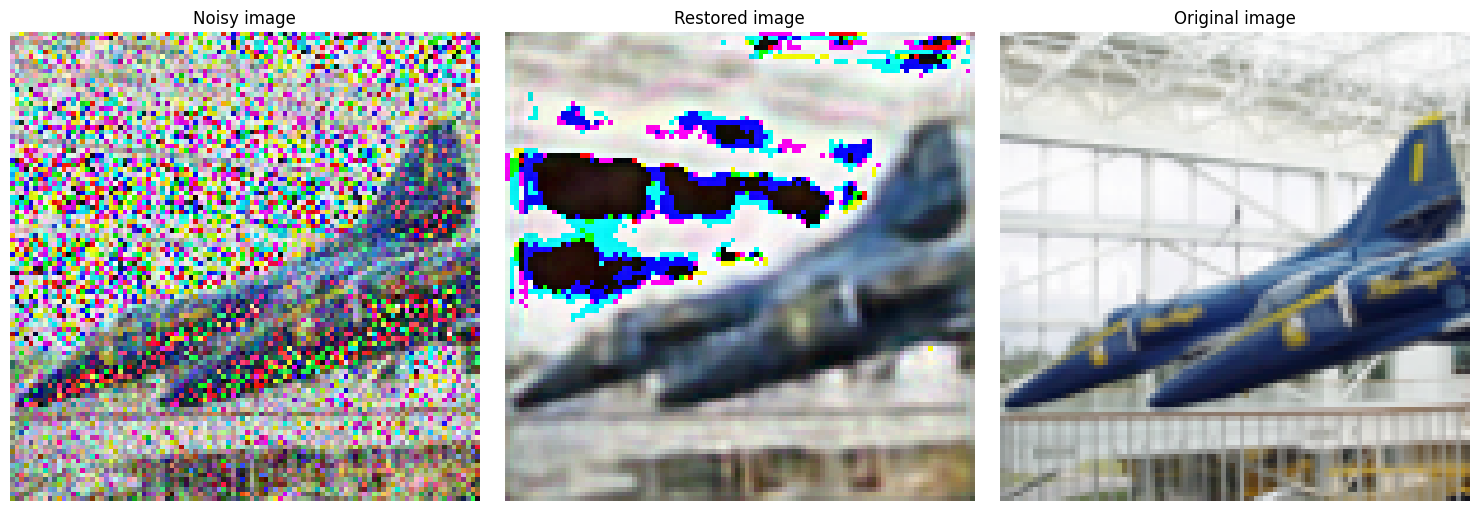

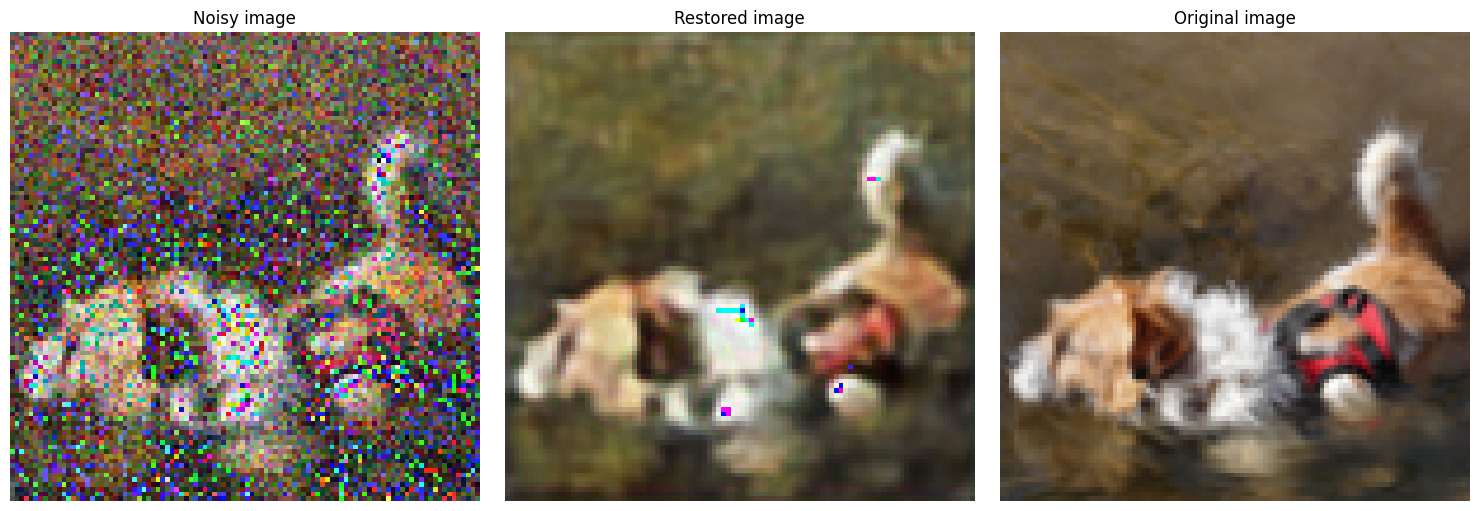

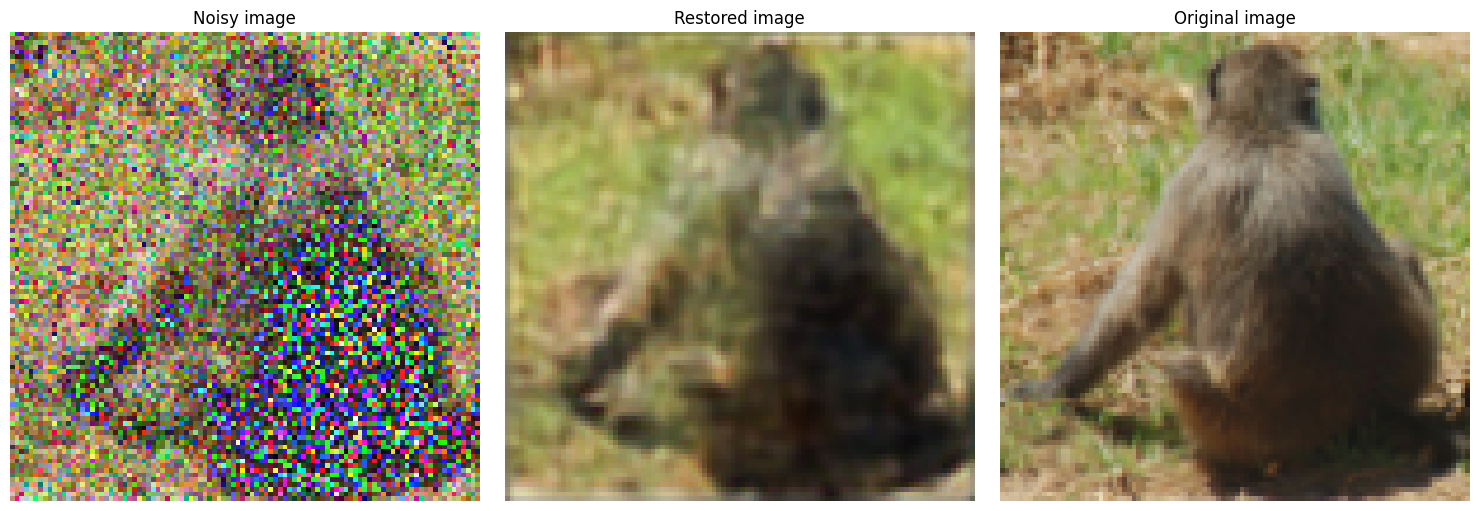

In [16]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      _, target, _, input = data
      input = input.to(device) / 255
      target = target / 255
      output = model(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      target = target[0].numpy()

      plt.figure(figsize=(15,5))
      plt.subplot(131), plt.imshow(input), plt.axis('off'), plt.title('Noisy image', size=12)
      plt.subplot(132), plt.imshow(output), plt.axis('off'), plt.title('Restored image', size=12)
      plt.subplot(133), plt.imshow(target), plt.axis('off'), plt.title('Original image', size=12)
      plt.tight_layout()
      plt.show()

      k+=1
      if k == 10:
        break

## ЗАДАНИЕ 4.1

Ваша задача — заполнить слои в наброске автоэнкодера, запустить обучение и получить результат метрики PSNR не менее 23.

In [10]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.Flatten(start_dim=1),
        nn.Linear(64 * 50 * 50, 512)
    )
    self.decoder = nn.Sequential(
        nn.Linear(512, 64 * 50 * 50),
        nn.Unflatten(1, (64, 50, 50)),
        nn.ConvTranspose2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(32, 3, 3, 1, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    out = self.decoder(x)
    return out

In [11]:
model_ae = AutoEncoder().to(device)
model_ae.eval()
output = model_ae(torch.ones(1, 3, 100, 100).to(device))

In [12]:
dataset = train_val_dataset(dataset)

train_dataset = dataset['val']

batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)

criterion = nn.MSELoss()

lr = 5e-4
optimizer = optim.AdamW(model_ae.parameters(), lr=lr)

In [13]:
epochs = 55
for epoch in range(1, epochs+1):
  epoch_loss = 0
  model_ae.train()
  for iteration, data in enumerate(train_dataloader):

      _, target, _, input = data
      input, target = input.to(device)/255, target.to(device)/255

      output = model_ae(input)

      loss = criterion(output, target.permute(0, 3, 1, 2))
      epoch_loss += loss.item()

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


      # print("===> Epoch[{}]({}/{}): "
      #       "Loss: {:.4f}".format(epoch, iteration,
      #                             len(train_dataloader),
      #                             loss.item()))
  print("===> Epoch {} Complete: "
        "Avg. Loss: {:.4f}".format(epoch,
                                    epoch_loss / len(train_dataloader)))


  avg_psnr = 0
  model_ae.eval()
  with torch.no_grad():
      for data in train_dataloader:
        _, target, _, input = data
        input, target = input.to(device)/255, target.to(device)/255
        output = model_ae(input)
        mse = criterion(output, target.permute(0, 3, 1, 2))
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
  print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(train_dataloader)))

===> Epoch 1 Complete: Avg. Loss: 0.0691
===> Avg. PSNR: 12.5501 dB
===> Epoch 2 Complete: Avg. Loss: 0.0469
===> Avg. PSNR: 13.9685 dB
===> Epoch 3 Complete: Avg. Loss: 0.0370
===> Avg. PSNR: 14.8385 dB
===> Epoch 4 Complete: Avg. Loss: 0.0313
===> Avg. PSNR: 15.3575 dB
===> Epoch 5 Complete: Avg. Loss: 0.0274
===> Avg. PSNR: 16.0582 dB
===> Epoch 6 Complete: Avg. Loss: 0.0240
===> Avg. PSNR: 16.5059 dB
===> Epoch 7 Complete: Avg. Loss: 0.0219
===> Avg. PSNR: 16.9161 dB
===> Epoch 8 Complete: Avg. Loss: 0.0203
===> Avg. PSNR: 16.9106 dB
===> Epoch 9 Complete: Avg. Loss: 0.0193
===> Avg. PSNR: 17.3785 dB
===> Epoch 10 Complete: Avg. Loss: 0.0183
===> Avg. PSNR: 17.6948 dB
===> Epoch 11 Complete: Avg. Loss: 0.0172
===> Avg. PSNR: 17.9270 dB
===> Epoch 12 Complete: Avg. Loss: 0.0164
===> Avg. PSNR: 18.1214 dB
===> Epoch 13 Complete: Avg. Loss: 0.0158
===> Avg. PSNR: 18.1551 dB
===> Epoch 14 Complete: Avg. Loss: 0.0147
===> Avg. PSNR: 18.5615 dB
===> Epoch 15 Complete: Avg. Loss: 0.0137
=

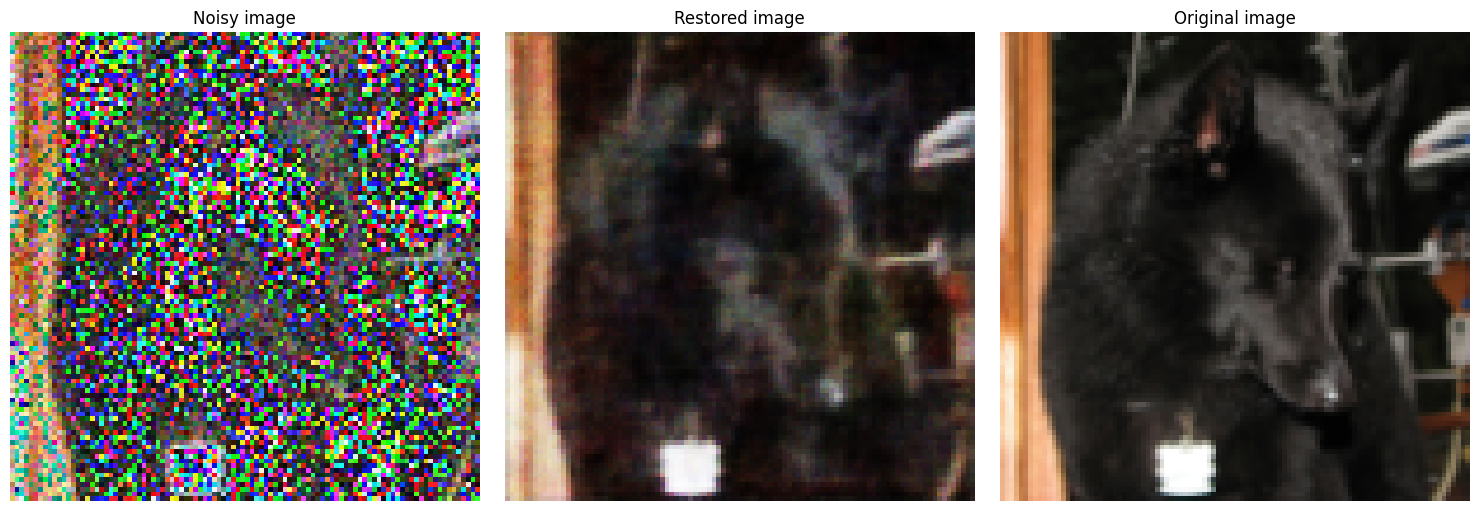

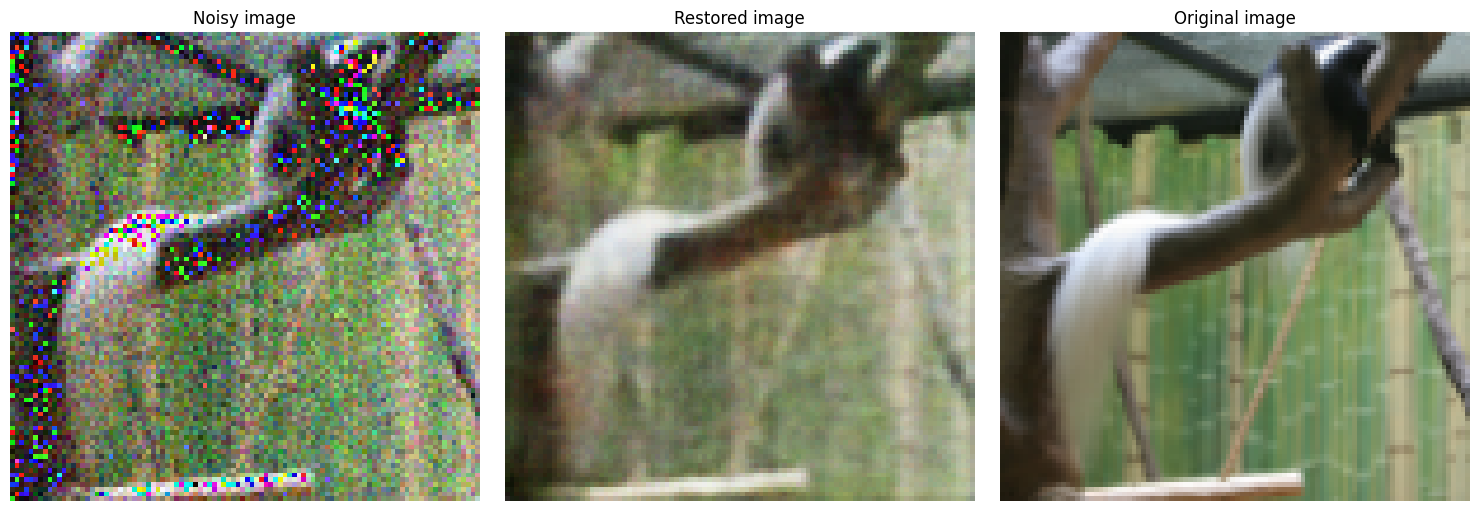

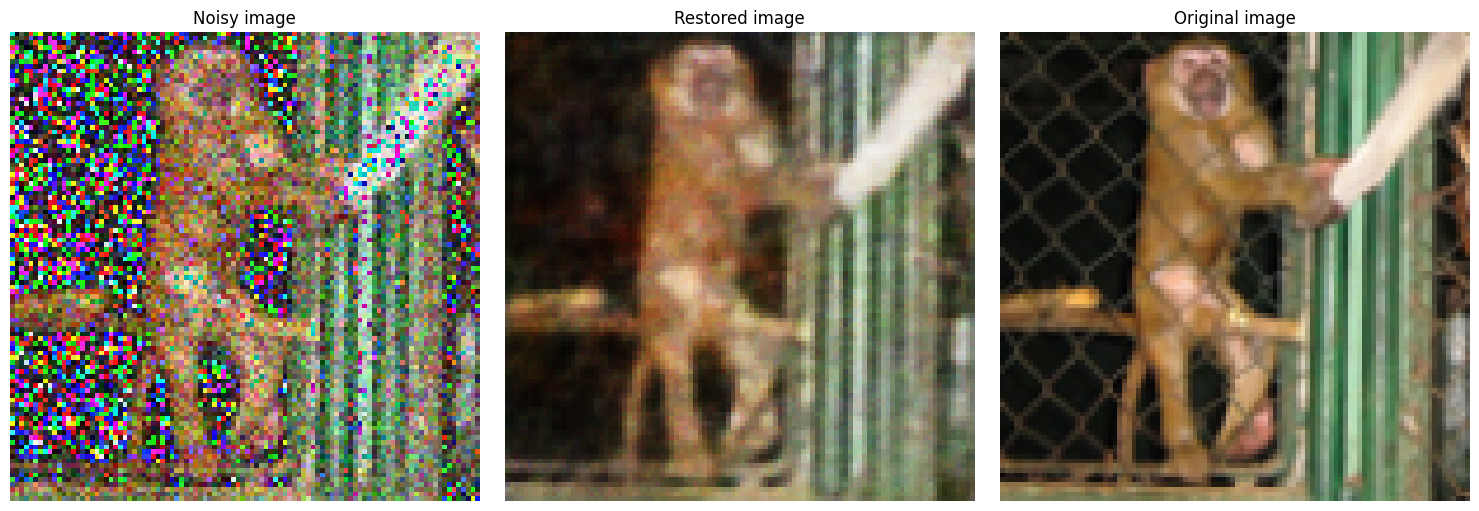

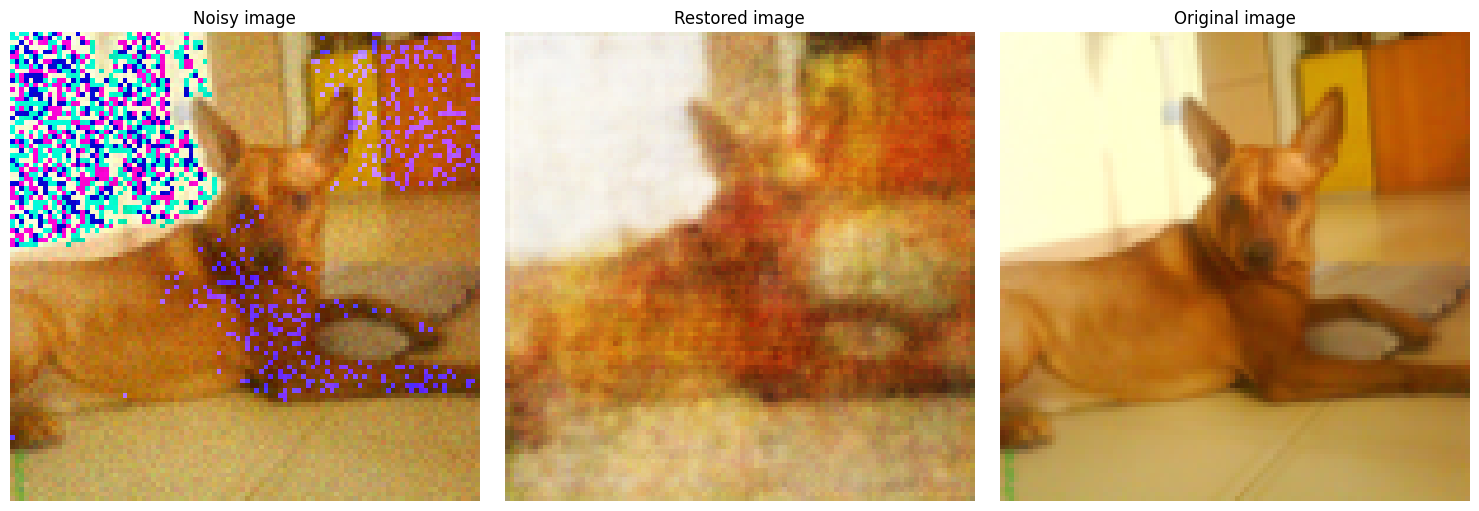

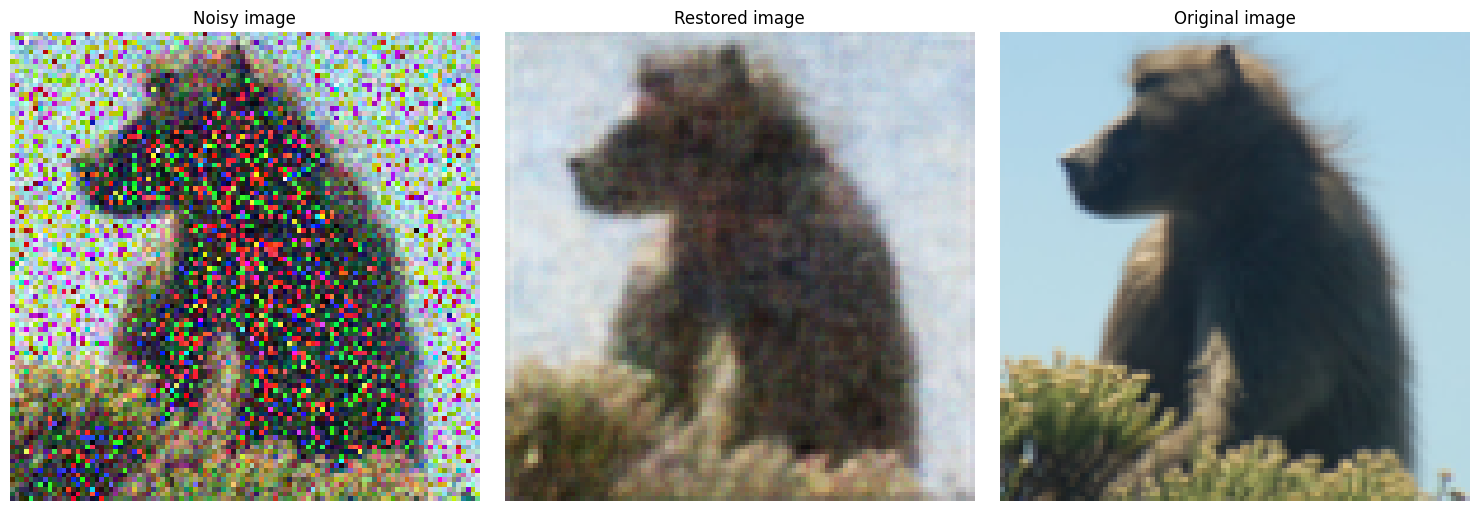

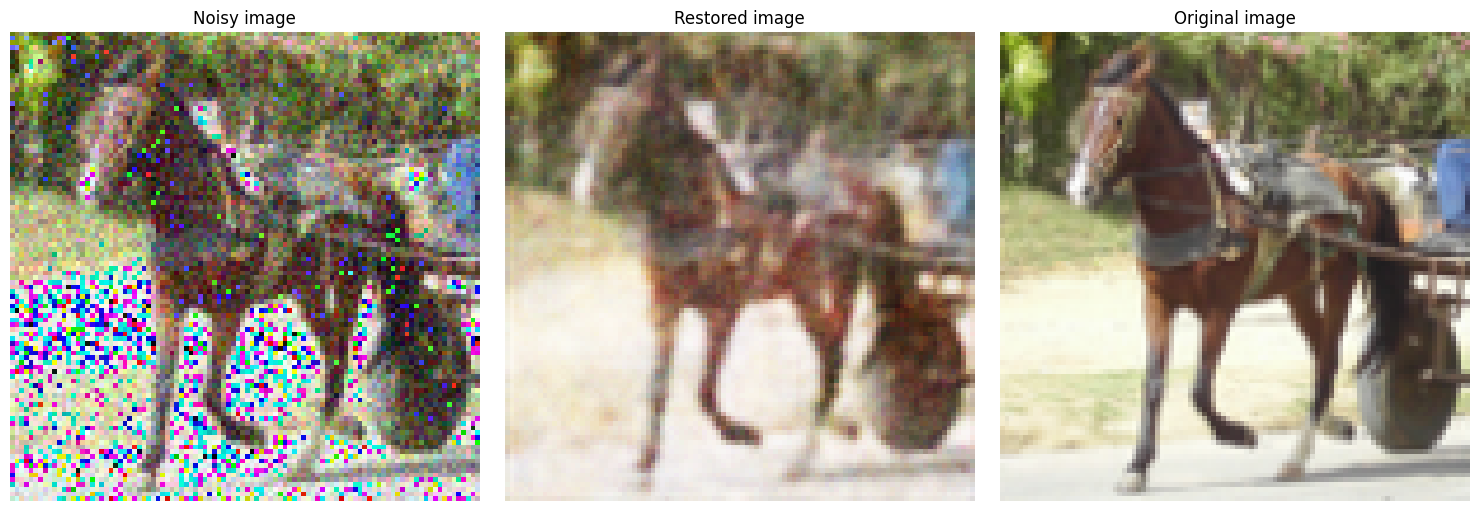

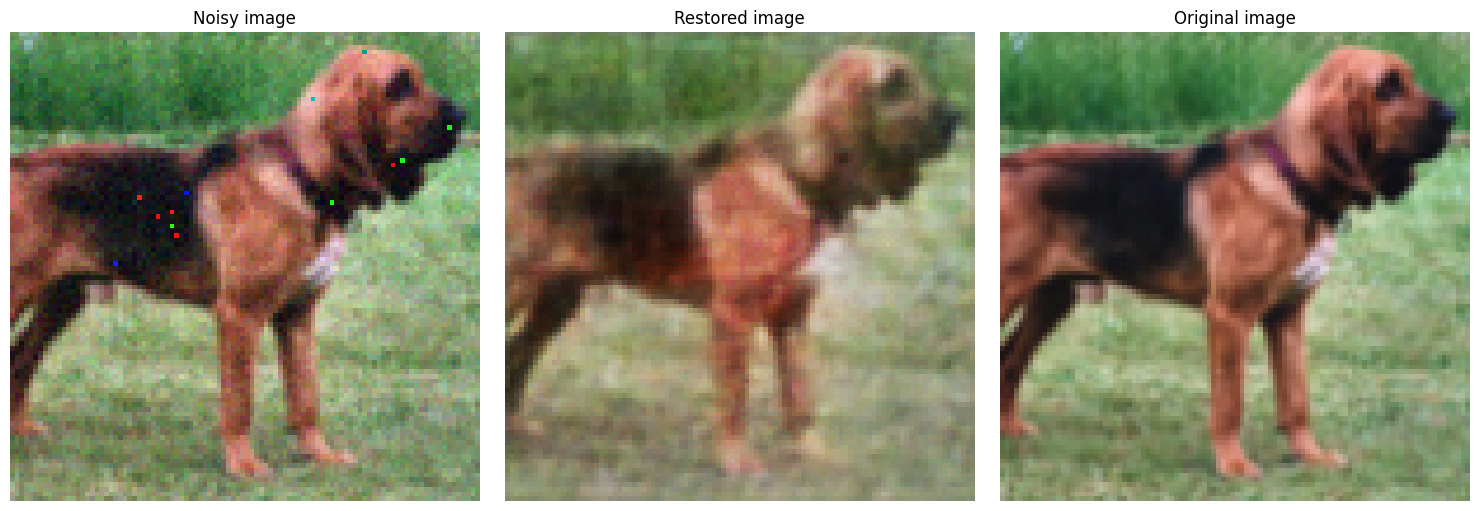

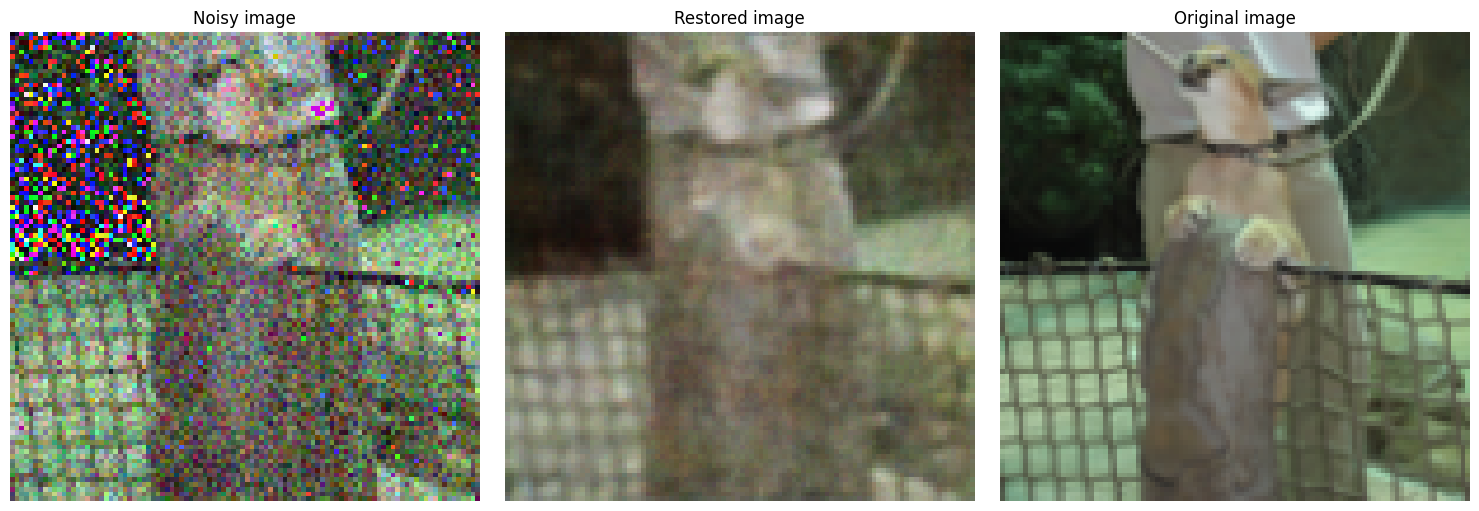

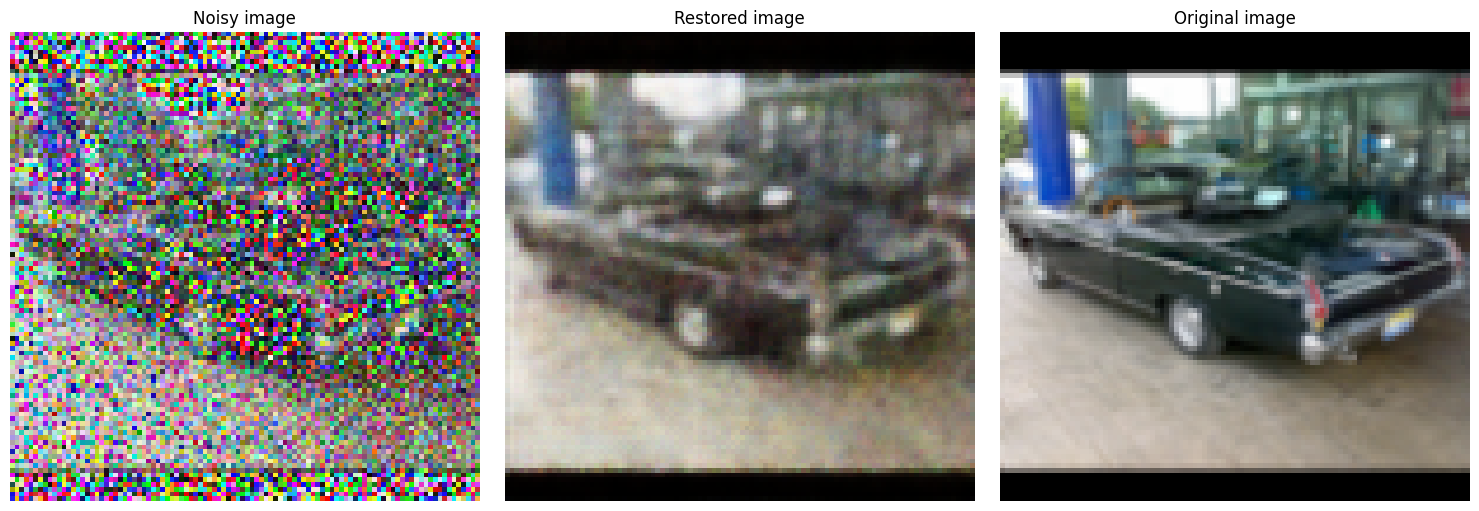

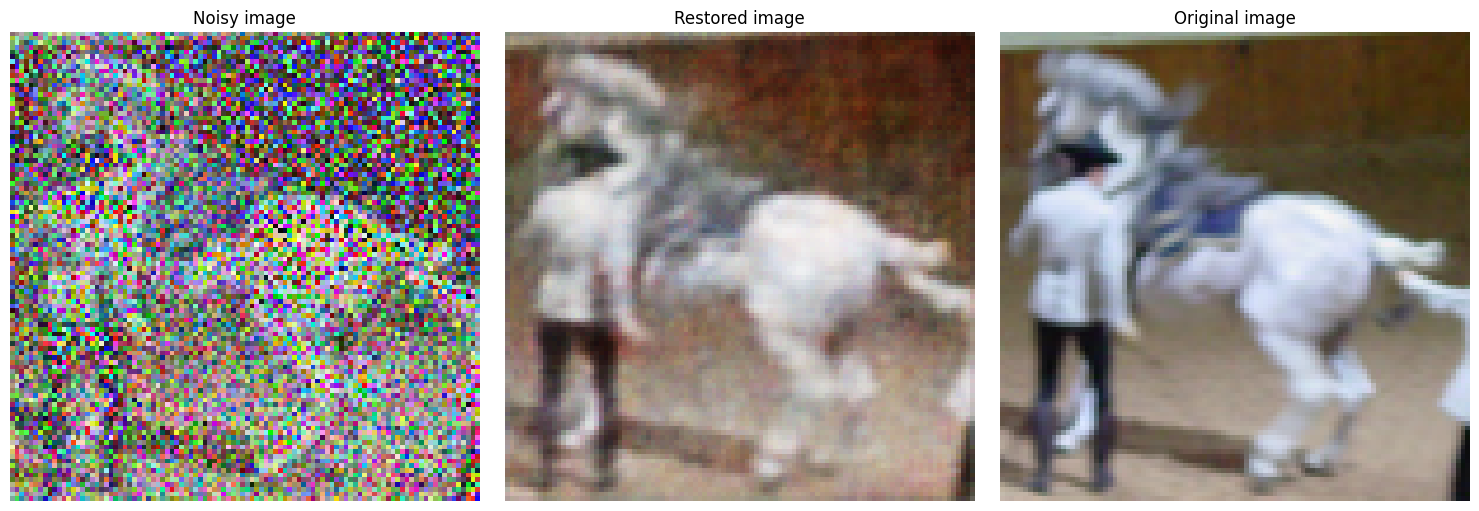

In [14]:
k = 0
with torch.no_grad():
    for data in train_dataloader:
      _, target, _, input = data
      input = input.to(device) / 255
      target = target / 255
      output = model_ae(input)
      output = (output[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      input = (input[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
      target = target[0].numpy()

      plt.figure(figsize=(15,5))
      plt.subplot(131), plt.imshow(input), plt.axis('off'), plt.title('Noisy image', size=12)
      plt.subplot(132), plt.imshow(output), plt.axis('off'), plt.title('Restored image', size=12)
      plt.subplot(133), plt.imshow(target), plt.axis('off'), plt.title('Original image', size=12)
      plt.tight_layout()
      plt.show()

      k+=1
      if k == 10:
        break